# In case of using colab
Remember to connect to your drive and upload the dataset if you want to repeat several times  this tutorial

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content

Mounted at /content/drive
/content


# Using YOLOv7 for car detection
To train a neural network for object detection is required to download a dataset. In this case we are going to use the car-detection dataset for vehicle detection. To download the file is required to go to Kaggle and download the file in YOLO v7 PyTorch format.


[car-detection-dataset](https://drive.google.com/drive/folders/1Xkak8cDZB2WGyJlcsinW2XZ7b7UKOZcN?usp=sharing)



In [2]:
!unzip '/content/drive/MyDrive/archive.zip'

Archive:  /content/drive/MyDrive/archive.zip
   creating: archive/
   creating: archive/data/
  inflating: archive/data/sample_submission.csv  
  inflating: archive/data/train_solution_bounding_boxes (1).csv  
   creating: archive/data/testing_images/
  inflating: archive/data/testing_images/vid_5_25100.jpg  
  inflating: archive/data/testing_images/vid_5_25120.jpg  
  inflating: archive/data/testing_images/vid_5_25140.jpg  
  inflating: archive/data/testing_images/vid_5_25160.jpg  
  inflating: archive/data/testing_images/vid_5_25180.jpg  
  inflating: archive/data/testing_images/vid_5_25200.jpg  
  inflating: archive/data/testing_images/vid_5_25220.jpg  
  inflating: archive/data/testing_images/vid_5_25240.jpg  
  inflating: archive/data/testing_images/vid_5_25260.jpg  
  inflating: archive/data/testing_images/vid_5_26320.jpg  
  inflating: archive/data/testing_images/vid_5_26400.jpg  
  inflating: archive/data/testing_images/vid_5_26420.jpg  
  inflating: archive/data/testing_images

# Download YOLOv7 Repository
Then we need the source code to build and train the neural network. You may need to install the dependencies required for this repository.

In [1]:
!git clone https://github.com/LuisCossioUOH/HandsOnDetection.git
%cd HandsOnDetection

fatal: destination path 'HandsOnDetection' already exists and is not an empty directory.
/content/HandsOnDetection


In [2]:
with open("requirements.txt", "r") as archivo:
    lineas = archivo.readlines()

# Reemplazos específicos
for i, linea in enumerate(lineas):
    if linea.startswith("torch>="):
        lineas[i] = "torch<=2.4.0\n"
    elif linea.startswith("torchvision>=") or "torchvision" in linea:
        lineas[i] = "torchvision\n"

# Escribir nuevamente el archivo con las líneas modificadas
with open("requirements.txt", "w") as archivo:
    archivo.writelines(lineas)

In [3]:
!pip install -r requirements.txt ### UNCOMMENT IF NOT ENOUGH DEPENDENCIES

In [4]:
import os
import cv2
import math
import yaml
import time
import random
import logging

import numpy as np
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
from argparse import Namespace
import matplotlib.pyplot as plt


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data

from torch.cuda import amp

import evaluation

from models.yolo import Model
from utils.autoanchor import check_anchors
from utils.datasets import create_dataloader, LoadImagesAndLabels, letterbox

from utils.general import labels_to_class_weights, init_seeds, fitness, \
    check_file, check_img_size, set_logging, one_cycle, colorstr, non_max_suppression
from utils.google_utils import attempt_download
from utils.loss import ComputeLoss, ComputeLossAuxOTA
from utils.torch_utils import ModelEMA, intersect_dicts, torch_distributed_zero_first
from utils.wandb_logging.wandb_utils import WandbLogger
from utils.plots import color_list, plot_one_box, plot_images,output_to_target

from train_example import training_session, get_files_datasets, create_ellipse_dataloaders


logger = logging.getLogger(__name__)
%matplotlib inline

# Understanding images

In [ ]:
image = np.zeros([100,100,3],dtype=np.uint8)
plt.imshow(image)

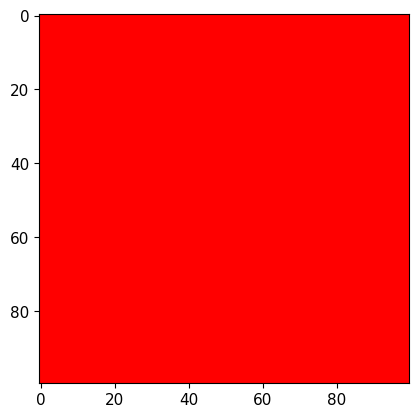

In [ ]:
image[:,:,0] = 255
plt.imshow(image)

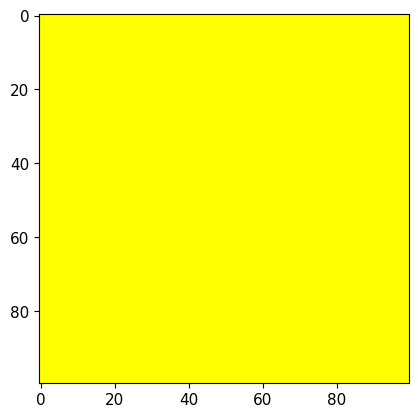

In [ ]:
# image[:,:,0] = 0
image[:,:,1] = 255

plt.imshow(image)

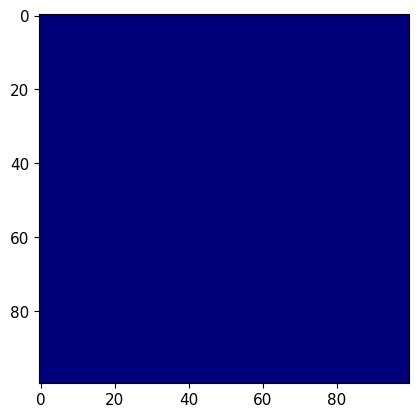

In [ ]:
image[:,:,0] = 0
image[:,:,1] = 0
image[:,:,2] = 123

plt.imshow(image)

# Setting up training
Here we have several settings for the training. Nonetheless we recommend using the default settings and perhaps change the batch-size to manga CUDA out of memory error if you are using the GPU. Later you can learn what does what.


In [5]:
opt = Namespace()

##### PATH SETTINGS ################
opt.data = 'data/vehicle.yaml'
opt.cfg = 'cfg/training/yolov7-vehicle.yaml'
opt.hyp = 'data/hyp.scratch.custom.yaml'
opt.project = 'train_car_detection'
opt.data, opt.cfg, opt.hyp = check_file(opt.data), check_file(opt.cfg), check_file(opt.hyp)  # check files
assert len(opt.cfg) or len(opt.weights), 'either --cfg or --weights must be specified'
opt.name = 'yolov7-6e'
opt.save_dir = 'runs'

##### Dataset info ####################################
opt.update_dataset = True
opt.data_train ='../archive/data' #
opt.names_classes = ['vehicle']
opt.nc = 1
opt.single_cls = True

##### HYPER-PARAMS OPTIMIZATION ########################
opt.weights = ''# '/home/luis/2022/yolov7/weights/yolov7-e6_training.pt'
opt.batch_size = 2
opt.device = 'cuda' if torch.cuda.is_available() else 'cpu'
opt.multi_scale = False
opt.epochs = 2
opt.img_size = [480, 480]
opt.img_size.extend([opt.img_size[-1]] * (2 - len(opt.img_size)))  # extend to 2 sizes (train, test)
opt.adam = True
opt.accumulate = 2
########################################################

#### DEFAULT SETTING (DON'T CHANGE)
opt.seed = 333
opt.save_interval = 10
opt.world_size = 1
opt.rect = True
opt.global_rank = -1
set_logging(opt.global_rank)
opt.resume= False
opt.workers = 8
opt.cache_images = False
opt.label_smoothing = 0.0
opt.bbox_interval = -1
opt.save_period = -1
opt.noautoanchor = False
opt.nosave = False
opt.notest = False
opt.v5_metric = False
########################################################

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
with open(opt.hyp) as f:
    hyp = yaml.load(f, Loader=yaml.SafeLoader)  # load hyps

logger.info(opt)

logger = logging.getLogger(__name__)

# Train


## Understanding the dataset

![image_dataset](https://sebastianraschka.com/images/blog/2022/datapipes/card.png)

A key component in the training of a neural network is the dataset. Pytorch uses Dataset objects to fetch data from files. For Object detection each dataset contains the image and a corresponding file with the location of objects in said image, in this case a .txt file.
To add further customization and mini-batch training capabilities we use Dataloaders. Dataloaders are basically a wrapper of the dataset with these extra functionalities.


Datasets have indexed each file in the dataset and only need a precise index to give the corresponding image and label.



## Crear labels faltantes (no es necesario)

In [ ]:
%%writefile rellena_labels.py
import os
import argparse

def main(data_dir, label_dir):
    if not os.path.isdir(label_dir):
      raise FileNotFoundError(f"La carpeta de entrada no existe: {label_dir}")

    for filename_data in os.listdir(data_dir):
      filename_data = filename_data.split(".")[0]

      crear_archivo = True
      for filename_label in os.listdir(label_dir):
        filename_label = filename_label.split(".")[0]

        if filename_data == filename_label:
          crear_archivo = False
          break

      if crear_archivo:
        print("Falta:", filename_data, ".txt")

        with open(label_dir + "/" + filename_data + ".txt", "x", encoding="utf-8") as f:
          f.write("")


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Procesa archivos desde una carpeta de entrada a una de salida.")
    parser.add_argument('--data_dir', required=True, help='Ruta a la carpeta de entrada')
    parser.add_argument('--label_dir', required=True, help='Ruta a la carpeta de salida')
    args = parser.parse_args()

    main(args.data_dir, args.label_dir)

Writing rellena_labels.py


In [ ]:
!python rellena_labels.py --data_dir '../archive/data/images' --label_dir '../archive/data/labels'

Falta: vid_4_19360 .txt
Falta: vid_4_3280 .txt
Falta: vid_4_22920 .txt
Falta: vid_4_7320 .txt
Falta: vid_4_19700 .txt
Falta: vid_4_18260 .txt
Falta: vid_4_7080 .txt
Falta: vid_4_14660 .txt
Falta: vid_4_22760 .txt
Falta: vid_4_7580 .txt
Falta: vid_4_25940 .txt
Falta: vid_4_20280 .txt
Falta: vid_4_22480 .txt
Falta: vid_4_10820 .txt
Falta: vid_4_22100 .txt
Falta: vid_4_26020 .txt
Falta: vid_4_11320 .txt
Falta: vid_4_22360 .txt
Falta: vid_4_1740 .txt
Falta: vid_4_22040 .txt
Falta: vid_4_10360 .txt
Falta: vid_4_21700 .txt
Falta: vid_4_26260 .txt
Falta: vid_4_21120 .txt
Falta: vid_4_23580 .txt
Falta: vid_4_14200 .txt
Falta: vid_4_29680 .txt
Falta: vid_4_20140 .txt
Falta: vid_4_13100 .txt
Falta: vid_4_17380 .txt
Falta: vid_4_13980 .txt
Falta: vid_4_22380 .txt
Falta: vid_4_14800 .txt
Falta: vid_4_22320 .txt
Falta: vid_4_26780 .txt
Falta: vid_4_9180 .txt
Falta: vid_4_14420 .txt
Falta: vid_4_2320 .txt
Falta: vid_4_20980 .txt
Falta: vid_4_13020 .txt
Falta: vid_4_10200 .txt
Falta: vid_4_18960 .txt

In [ ]:
# !python rellena_labels.py --data_dir '../archive/data/testing_images' --label_dir '../archive/data/labels'

## Testing the dataset
1. Using the example of the bounding box given generate a code to plot every bounding box in the image
2. Modified the code to plot a random image from the dataset
3. Using the dataset in the dataloader for test (dataloader_test.dataset), and analize the difference between the two datasets.



In [ ]:
ts = training_session(hyp, opt, device)
max_stride = ts.max_stride
dataset_train, dataloader_train, dataloader_test, imgsz = get_files_datasets(hyp, opt, ts.data_dict, max_stride)

labels.shape: torch.Size([1, 6])


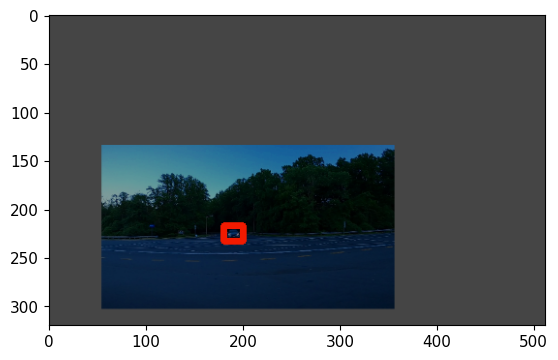

In [ ]:
index_item = 0  # Estaba en 900
imgs, labels, paths, _ = dataset_train[index_item]
img = imgs.cpu().numpy().transpose(1,2,0)

imgs = imgs[None]
imgs = imgs.to(device, non_blocking=True).float() / 255.0  # uint8 to float32, 0-255 to 0.0-1.0
colors = np.array([[0.95,0.1,0.0],[0.8,0.4,0.2],[0.1,1.0,0.1]]) * 255
thickness=6
dim_img = np.array(list(reversed(img.shape[:2])))

print(f"labels.shape: {labels.shape}") #
pt1 = np.array(labels[0, 2:4] * dim_img,dtype=np.int32)
dims = np.array(labels[0, 4:6] * dim_img,dtype=np.int32)
pt2 = pt1 + dims//2
pt1 = pt1 - dims//2
c_point = colors[int(labels[0,1])]

img = cv2.rectangle(img.copy(), pt1.tolist(), pt2.tolist(), color=c_point, thickness=thickness)

plt.imshow(img)

In [ ]:
cuenta = 0
for idx in range(len(dataset_train)):
    _, labels, _, _ = dataset_train[idx]
    if labels.shape[0] > 0:
        print(f"Found index with labels: {idx}")
        cuenta += 1
        break

print(cuenta)

Found index with labels: 0
1


### Difference with the dataloader
1. Indicates what's the purpose for the first column in the targets tensors

In [ ]:
for (imgs, targets, paths, _)  in dataloader_train:
    print(imgs.size())
    print(targets)
    print(paths)
    break

torch.Size([2, 3, 320, 512])
tensor([[0.00000, 0.00000, 0.63012, 0.60317, 0.05087, 0.06321]])
['../archive/data/images/vid_4_1000.jpg', '../archive/data/images/vid_4_3740.jpg']


In [ ]:
# del ts, dataloader_train, dataset_train, dataloader_test, imgsz

In [ ]:
!pwd
%cd /content/HandsOnDetection

/content
/content/HandsOnDetection


# Training

In its simplest form the training pipeline will consist of one iteration across every sample. This involves only a simple cycle across the dataloader.


The process consist of 5 operations:
1. The optimizer grads are set to 0. This is done because each iteration the gradients receive more gradient and failing to set it to 0 at the beginning of the iteration will cause the gradient to accumulate across all the training.  
2. The network produce a prediction for each image in the batch
3. A criterion function is used to calculate the loss/error of the prediction. In this case the loss is composed of a L2 distance loss and a classification loss (cross-entropy)
4. The gradient is propagated backward in the network updating the gradients of each neuron.
5. The optimizer updates the weights based on the gradients.



In this case the train function is a little more complicated. It's basically a shrunken down version of the training pipeline for the original YOLOv7, but still rather complex to account for several steps. Take a look and try to find each component.



## Basic Problem: Ellipse detection
You can experiment with the HYPER-PARAMS OPTIMIZATION settings.

1. Plot random examples from the dataset
2. Train the model and test some modifications to the  hyper-parameters. Try and predict the result before it happens.


In [ ]:
########################################################
##### Dataset info ####################################
########################################################
opt.update_dataset = True
opt.data_train ='' #
opt.nc = 3
opt.names_classes = ['ellipse{:d}'.format(i) for i in range(opt.nc)] # ['vehicle'] #['ripe','unripe','green']
opt.single_cls = opt.nc==1

##### HYPER-PARAMS OPTIMIZATION ########################
opt.weights = '' # '/home/luis/2022/yolov7/weights/yolov7-e6_training.pt'
opt.batch_size = 8
opt.device = 'cuda' if torch.cuda.is_available() else 'cpu'
opt.multi_scale = False
opt.epochs = 30
opt.img_size = [192, 192]
opt.img_size.extend([opt.img_size[-1]] * (2 - len(opt.img_size)))  # extend to 2 sizes (train, test)
opt.adam = True
opt.accumulate = 1
########################################################

In [ ]:
ts = training_session(hyp, opt, device)
max_stride = ts.max_stride
dataset_ellipse, dataloader_ellipse, dataloader_ellipse_test, \
imgsz = create_ellipse_dataloaders(opt.img_size,opt.batch_size,max_stride,workers=opt.workers,
                                   n_classes = opt.nc, n_ellipses=4,n_images=200)

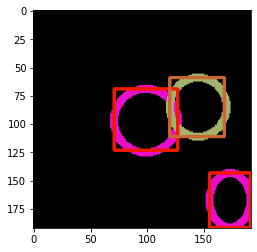

In [ ]:
ts.setup_dataset(opt,dataset_ellipse, dataloader_ellipse, dataloader_ellipse_test, imgsz=imgsz)
ts.setup_training(opt)
ts.train(opt,device)


autoanchor: Analyzing anchors... anchors/target = 6.00, Best Possible Recall (BPR) = 1.0000


  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 15 but got size 16 for tensor number 1 in the list.

### Evaluation

In [ ]:
model = ts.model
model.eval()
model.half()
torch.cuda.empty_cache()
print("MODEL READY")

NameError: name 'ts' is not defined

torch.Size([1, 3, 192, 192])


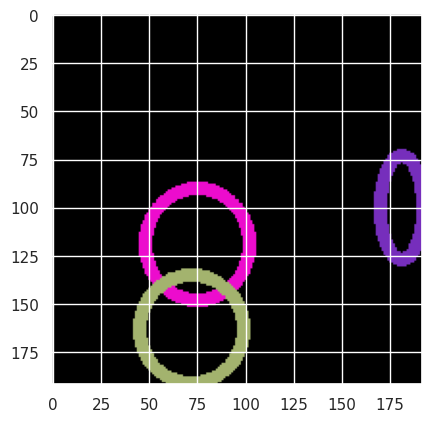

In [ ]:
imgs, labels, paths, _ = dataset_ellipse[0]
img = imgs.cpu().numpy().transpose(1,2,0)
imgs = imgs[None].to(device, non_blocking=True).float() / 255.0  # uint8 to float32, 0-255 to 0.0-1.0
print(imgs.size())
with torch.no_grad():
    out = model(imgs.half())


plt.imshow(img)
# plt.grid()

### Plot the predictions
1. Using the non_max_suppression function, already implemented, plot the predictions with enough confidence

tensor([[ 43.78125, 133.75000,  99.12500, 192.50000,   0.92041,   1.00000],
        [ 47.68750,  89.37500, 100.31250, 148.75000,   0.85205,   0.00000],
        [169.75000,  72.81250, 191.75000, 127.68750,   0.44556,   2.00000]], device='cuda:0')
(3, 6)


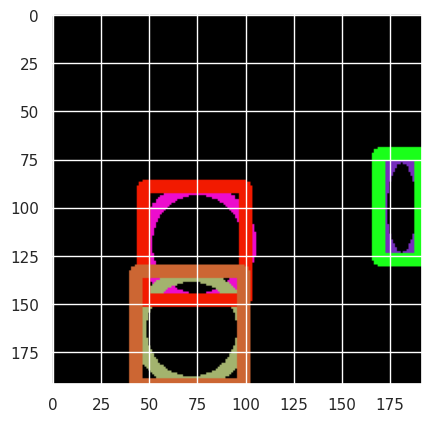

In [ ]:
iou_thres = 0.5
conf_threshold = 0.3
nms_outputs = non_max_suppression(out[0].detach(), conf_thres=conf_threshold, iou_thres=iou_thres,)[0]
print(nms_outputs)
predictions = nms_outputs.cpu().numpy()
colors = np.array([[0.95,0.1,0.0],[0.8,0.4,0.2],[0.1,1.0,0.1]]) * 255
thickness=6

print(predictions.shape)
for pred in predictions:
  x1, y1, x2, y2, confianza, clase,  = pred
  pt1 = (int(x1), int(y1))
  pt2 = (int(x2), int(y2))
  c = colors[int(clase)]
  cv2.rectangle(img, pt1, pt2, color=c, thickness=thickness)


plt.imshow(img)

In [ ]:
# del ts, dataloader_ellipse, dataset_ellipse, dataloader_ellipse_test, imgsz

## Real Problem: Car detection

1. Train the model for a real dataset.

In [10]:
opt.data = 'data/vehicle.yaml'
opt.cfg = 'cfg/training/yolov7-vehicle.yaml'
opt.hyp = 'data/hyp.scratch.custom.yaml'
opt.project = 'train_car_detection'
opt.data, opt.cfg, opt.hyp = check_file(opt.data), check_file(opt.cfg), check_file(opt.hyp)  # check files
assert len(opt.cfg) or len(opt.weights), 'either --cfg or --weights must be specified'
opt.name = 'yolov7-6e'
opt.save_dir = 'runs'

##### Dataset info ####################################
opt.update_dataset = True
opt.data_train ='../archive/data/images' #
opt.names_classes = ['vehicle']
opt.nc = 1
opt.single_cls = True

##### HYPER-PARAMS OPTIMIZATION ########################
opt.weights = 'yolov7-e6-vehicle.pt'# '/home/luis/2022/yolov7/weights/yolov7-e6_training.pt'
opt.batch_size = 8
opt.device = 'cuda' if torch.cuda.is_available() else 'cpu'
opt.multi_scale = False
opt.epochs = 30
opt.img_size = [676, 676]
opt.img_size.extend([opt.img_size[-1]] * (2 - len(opt.img_size)))  # extend to 2 sizes (train, test)
opt.adam = True
opt.accumulate = 2

In [11]:
ts = training_session(hyp, opt, device)
max_stride = ts.max_stride
dataset_train, dataloader_train, dataloader_test, imgsz = get_files_datasets(hyp, opt, ts.data_dict, max_stride)

train: Scanning '../archive/data/labels.cache' images and labels... 355 found, 646 missing, 0 empty, 0 corrupted: 100%|██████████| 1001/1001 [00:00<?, ?it/s]
val: Scanning '../archive/data/labels.cache' images and labels... 355 found, 646 missing, 0 empty, 0 corrupted: 100%|██████████| 1001/1001 [00:00<?, ?it/s]


/content/HandsOnDetection/train_example.py:258: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = amp.GradScaler(enabled=self.cuda)



autoanchor: Analyzing anchors... anchors/target = 4.73, Best Possible Recall (BPR) = 1.0000


  0%|          | 0/126 [00:00<?, ?it/s]/content/HandsOnDetection/train_example.py:302: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=self.cuda):
      0/29     2.09G   0.05038  0.001278         0   0.05166         1       704: 100%|██████████| 126/126 [00:55<00:00,  2.25it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:11<00:00, 10.65it/s]


                 all        1001           0           0           0           0           0


      1/29     4.62G   0.05128 0.0004528         0   0.05173         1       704: 100%|██████████| 126/126 [00:35<00:00,  3.54it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:09<00:00, 13.14it/s]


                 all        1001           0           0           0           0           0


      2/29     4.62G   0.05391 0.0004309         0   0.05434         1       704: 100%|██████████| 126/126 [00:40<00:00,  3.12it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 11.73it/s]


                 all        1001           0           0           0           0           0


      3/29     4.62G   0.05501 0.0005192         0   0.05553         1       704: 100%|██████████| 126/126 [00:35<00:00,  3.57it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 12.07it/s]


                 all        1001           0           0           0           0           0


      4/29     4.62G   0.04433 0.0004657         0   0.04479         1       704: 100%|██████████| 126/126 [00:40<00:00,  3.11it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 12.52it/s]


                 all        1001           0           0           0           0           0


      5/29     4.62G   0.04799 0.0004839         0   0.04847         1       704: 100%|██████████| 126/126 [00:35<00:00,  3.57it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 11.95it/s]


                 all        1001           0           0           0           0           0


      6/29     4.62G   0.04441 0.0005187         0   0.04492         1       704: 100%|██████████| 126/126 [00:40<00:00,  3.12it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:11<00:00, 10.78it/s]


                 all        1001           0           0           0           0           0


      7/29     4.62G   0.04505 0.0005322         0   0.04558         1       704: 100%|██████████| 126/126 [00:34<00:00,  3.63it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 12.03it/s]


                 all        1001           0           0           0           0           0


      8/29     4.62G   0.04337 0.0005422         0   0.04392         1       704: 100%|██████████| 126/126 [00:40<00:00,  3.14it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:11<00:00, 10.52it/s]


                 all        1001           0           0           0           0           0


      9/29     4.62G   0.04317 0.0005888         0   0.04376         1       704: 100%|██████████| 126/126 [00:34<00:00,  3.62it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 12.10it/s]


                 all        1001           0           0           0           0           0


     10/29     4.62G   0.03771  0.000591         0    0.0383         1       704: 100%|██████████| 126/126 [00:40<00:00,  3.15it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 11.95it/s]


                 all        1001           0           0           0           0           0


     11/29     4.62G    0.0397 0.0005221         0   0.04022         1       704: 100%|██████████| 126/126 [00:35<00:00,  3.60it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:09<00:00, 13.20it/s]


                 all        1001           0           0           0           0           0


     12/29     4.62G    0.0364  0.000532         0   0.03693         1       704: 100%|██████████| 126/126 [00:39<00:00,  3.17it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 12.46it/s]


                 all        1001           0           0           0           0           0


     13/29     4.62G   0.03318 0.0005419         0   0.03372         1       704: 100%|██████████| 126/126 [00:34<00:00,  3.68it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 12.15it/s]


                 all        1001           0           0           0           0           0


     14/29     4.62G   0.03447 0.0006269         0    0.0351         1       704: 100%|██████████| 126/126 [00:40<00:00,  3.15it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 12.57it/s]


                 all        1001           0           0           0           0           0


     15/29     4.62G   0.03271 0.0006244         0   0.03334         1       704: 100%|██████████| 126/126 [00:34<00:00,  3.66it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 12.16it/s]


                 all        1001           0           0           0           0           0


     16/29     4.62G   0.03339 0.0006802         0   0.03407         1       704: 100%|██████████| 126/126 [00:40<00:00,  3.13it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 11.79it/s]


                 all        1001           0           0           0           0           0


     17/29     4.62G   0.03213 0.0006334         0   0.03277         1       704: 100%|██████████| 126/126 [00:36<00:00,  3.48it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 11.85it/s]


                 all        1001           0           0           0           0           0


     18/29     4.62G   0.03421 0.0006927         0   0.03491         1       704: 100%|██████████| 126/126 [00:40<00:00,  3.09it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 11.78it/s]


                 all        1001           0           0           0           0           0


     19/29     4.62G   0.03195 0.0006889         0   0.03264         1       704: 100%|██████████| 126/126 [00:35<00:00,  3.59it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 12.25it/s]


                 all        1001           0           0           0           0           0


     20/29     4.62G   0.03207 0.0006648         0   0.03273         1       704: 100%|██████████| 126/126 [00:39<00:00,  3.16it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 12.11it/s]


                 all        1001           0           0           0           0           0


     21/29     4.62G   0.02814 0.0007747         0   0.02892         1       704: 100%|██████████| 126/126 [00:34<00:00,  3.61it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:09<00:00, 12.88it/s]


                 all        1001           0           0           0           0           0


     22/29     4.62G   0.03139 0.0007147         0    0.0321         1       704: 100%|██████████| 126/126 [00:40<00:00,  3.15it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 12.12it/s]


                 all        1001           0           0           0           0           0


     23/29     4.62G   0.03154 0.0007517         0   0.03229         1       704: 100%|██████████| 126/126 [00:34<00:00,  3.66it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 12.31it/s]


                 all        1001           0           0           0           0           0


     24/29     4.62G   0.03056   0.00074         0    0.0313         1       704: 100%|██████████| 126/126 [00:39<00:00,  3.15it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 12.19it/s]


                 all        1001           0           0           0           0           0


     25/29     4.62G    0.0277 0.0007681         0   0.02846         1       704: 100%|██████████| 126/126 [00:34<00:00,  3.66it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 11.62it/s]


                 all        1001           0           0           0           0           0


     26/29     4.62G   0.03059 0.0008851         0   0.03148         1       704: 100%|██████████| 126/126 [00:40<00:00,  3.14it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 12.56it/s]


                 all        1001           0           0           0           0           0


     27/29     4.62G   0.03345 0.0007007         0   0.03415         1       704: 100%|██████████| 126/126 [00:34<00:00,  3.65it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 12.01it/s]


                 all        1001           0           0           0           0           0


     28/29     4.62G   0.03095 0.0007847         0   0.03174         1       704: 100%|██████████| 126/126 [00:40<00:00,  3.14it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 12.07it/s]


                 all        1001           0           0           0           0           0


     29/29     4.62G   0.03223 0.0008461         0   0.03307         1       704: 100%|██████████| 126/126 [00:34<00:00,  3.64it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 126/126 [00:10<00:00, 11.71it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


                 all        1001           0           0           0           0           0


(0.0, 0.0, 0.0, 0.0, 0.04216669872403145, 0.006848657503724098, 0.0)

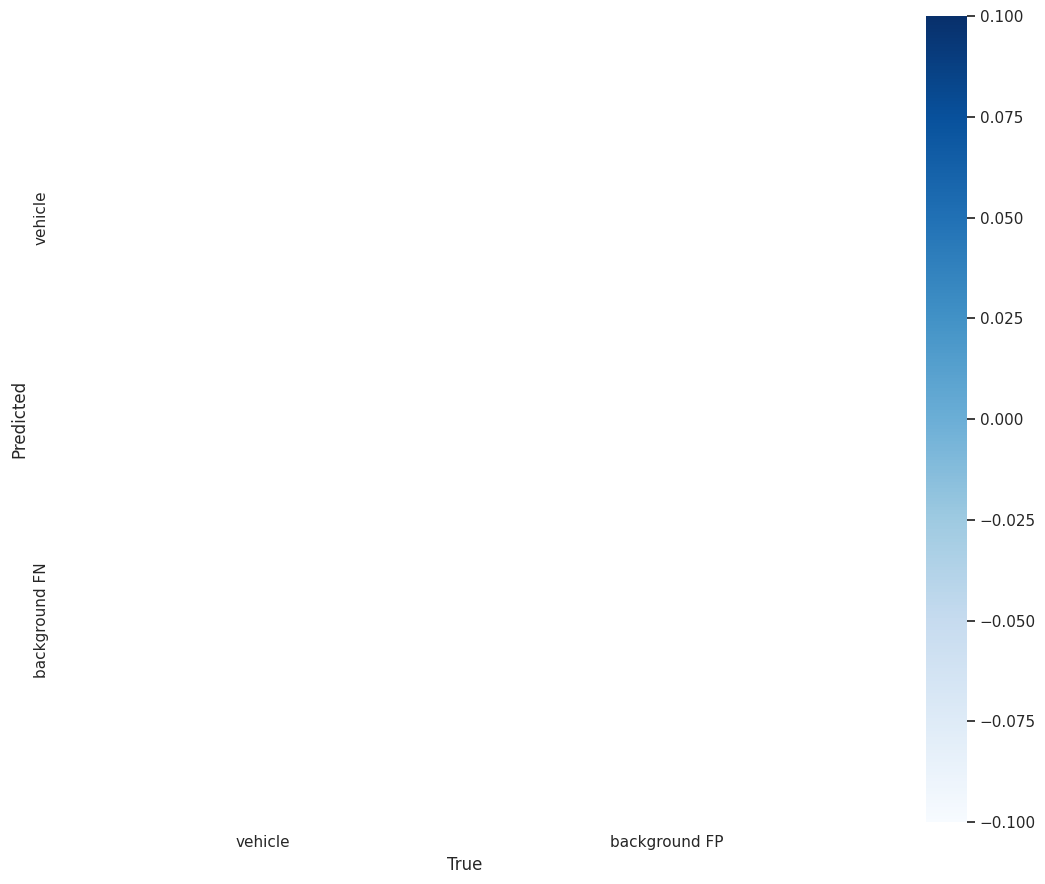

In [12]:
ts.setup_dataset(opt, dataset_train, dataloader_train, dataloader_test, imgsz)
ts.setup_training(opt)
ts.train(opt, device)

### Evaluation
1. Analize the metrics obtained in both the ellipse and run dataset

In [13]:
import pandas as pd

file = 'runs/results.txt'

column_names = ["epoch","MEM","Loss BBox","Loss Obj.","Loss Class","Total Loss","Process Number",
                "Size Img","P","R","AP 0.5","mAP@0.5:0.95","VAL Loss BBox", 'VAL Loss Obj.','VAL Loss CLS']
data = np.loadtxt(file,dtype=str)
data = pd.DataFrame(data,columns = column_names)

for name in ["Loss BBox","Loss Obj.","Loss Class","Total Loss","P","R","AP 0.5","mAP@0.5:0.95","VAL Loss BBox", 'VAL Loss Obj.','VAL Loss CLS']:
    data[name] = data[name].astype('float32')
print('data shape: ',data.shape)
data.sample(5)

data shape:  (30, 15)


,epoch,MEM,Loss BBox,Loss Obj.,Loss Class,...,AP 0.5,mAP@0.5:0.95,VAL Loss BBox,VAL Loss Obj.,VAL Loss CLS
11,11/29,4.62G,0.03970,0.000522,0.0,...,0.0,0.0,0.05213,0.004243,0.0
16,16/29,4.62G,0.03339,0.000680,0.0,...,0.0,0.0,0.04687,0.005797,0.0
5,5/29,4.62G,0.04799,0.000484,0.0,...,0.0,0.0,0.05264,0.003918,0.0
12,12/29,4.62G,0.03640,0.000532,0.0,...,0.0,0.0,0.05029,0.004913,0.0
6,6/29,4.62G,0.04441,0.000519,0.0,...,0.0,0.0,0.05883,2.912000,0.0


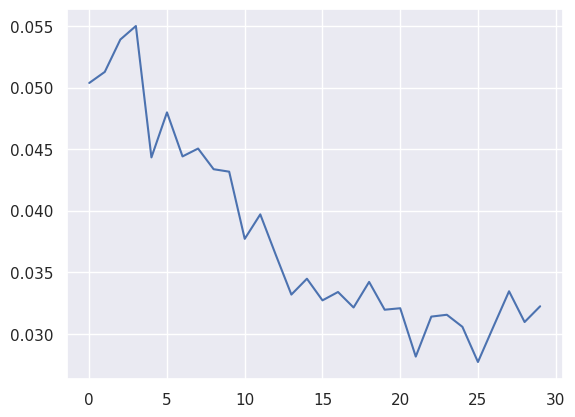

In [14]:
plt.plot(data.index,data['Loss BBox'])

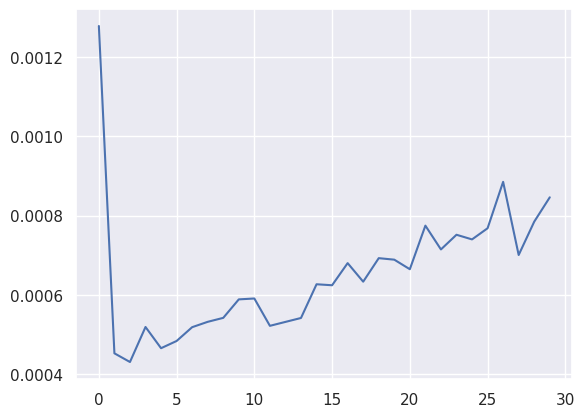

In [15]:
plt.plot(data.index,data['Loss Obj.'])

### Testing

In [16]:
torch.cuda.empty_cache()

In [17]:
model = ts.model
model.eval()
model.half()
print("MODEL READY")

# import collections
# ### OPTIONAL ###
# def load_pretrained(weights,opt,device,nc,strict=False):
#     ckpt = torch.load(weights, map_location=device)  # load checkpoint
#     model = Model(opt.cfg or ckpt['model'].yaml, ch=3, nc=nc, anchors=hyp.get('anchors')).to(
#         device)  # create
#     exclude = []
#     if type(ckpt['model'])==collections.OrderedDict:
#         state_dict = ckpt['model']  # to FP32
#     else:
#         state_dict = ckpt['model'].float().state_dict()  # to FP32
#     state_dict = intersect_dicts(state_dict, model.state_dict())  # intersect
#     model.load_state_dict(state_dict, strict=strict)  # load
#     return model


# model = load_pretrained('/home/luis/2024/Hands_on/yolov7/runs_ellipse/weights/last.pt',opt,device,opt.nc,
#                        strict=True)
# model.eval()
# model.half()
# print("MODEL READY")

MODEL READY


0.00026726722717285156


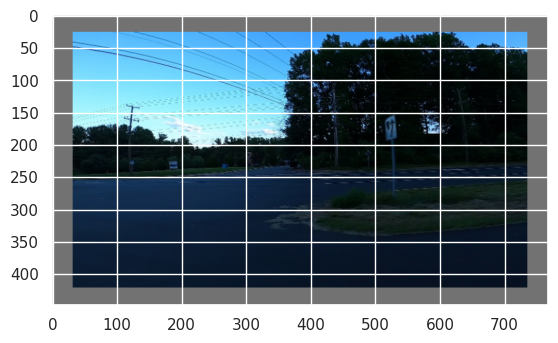

In [18]:
max_conf = 0.0
max_conf_index = -1

for i in range(len(dataloader_test.dataset)):
  imgs, labels, paths, _ = dataloader_test.dataset[i] #120
  # img = imgs.cpu().numpy().transpose(1,2,0)
  # plt.imshow(img)

  imgs = imgs[None].to(device, non_blocking=True).float() / 255.0  # uint8 to float32, 0-255 to 0.0-1.0
  # print(imgs.size())
  with torch.no_grad():
      out = model(imgs.half())


  conf = out[0][..., 4].max().item()
  if conf > max_conf:
        max_conf = conf
        max_conf_index = i

print(max_conf)

imgs, labels, paths, _ = dataloader_test.dataset[max_conf_index] #120
img = imgs.cpu().numpy().transpose(1,2,0)
plt.imshow(img)

imgs = imgs[None].to(device, non_blocking=True).float() / 255.0  # uint8 to float32, 0-255 to 0.0-1.0
with torch.no_grad():
  out = model(imgs.half())

tensor([], device='cuda:0', size=(0, 6))
tensor([], device='cuda:0', size=(0, 6))


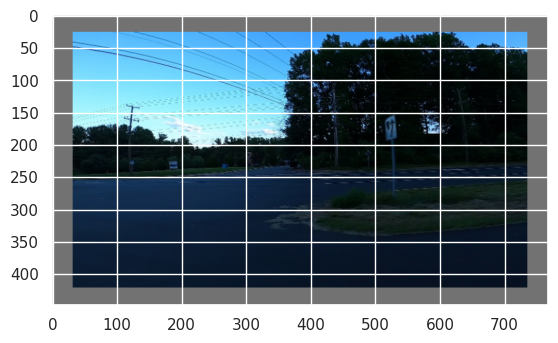

In [19]:
iou_thres = 0.5
conf_threshold = 0.0007#0.01
nms_outputs = non_max_suppression(out[0].detach(), conf_thres=conf_threshold, iou_thres=iou_thres,)[0]
print(nms_outputs)
predictions = nms_outputs.cpu().numpy()
colors = np.array([[0.95,0.1,0.0],[0.8,0.4,0.2],[0.1,1.0,0.1]]) * 255
thickness=6
for pred in predictions:
    pt1 = np.asarray(pred[:2],dtype=np.int32)
    pt2 = np.asarray(pred[2:4],dtype=np.int32)
    c_point = colors[int(pred[5])]
    img = cv2.rectangle(img.copy(),pt1.tolist(),pt2.tolist(),color=c_point,thickness=thickness)

plt.imshow(img)
# plt.grid()
print(nms_outputs)